In [1]:
import numpy as np
from numba import *
from astropy import units
from itertools import product
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize

In [2]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 2 # m/s

v_laser = 2 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

spawn molecules in a circle with a $1-\sigma$ width of $6/5\cdot 3.8$mm cm diameter at 1 cm distance from the cell. 
ACME measured a $1-\sigma$ width of 3.8 mm, 1 cm from the cell opening, with a cell aperture diameter of 5 mm.

In [3]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)
generate_random_transverse_velocities = lambda x: np.random.normal(0, vt_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [4]:
size = int(1e8)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

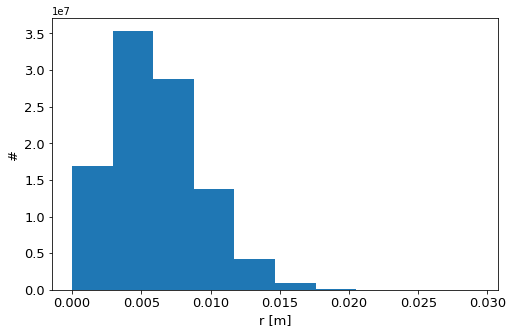

In [5]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(np.sum(coords**2, axis = 0)))
ax.set_xlabel('r [m]')
ax.set_ylabel('#')

set_fontsize(ax, 13)

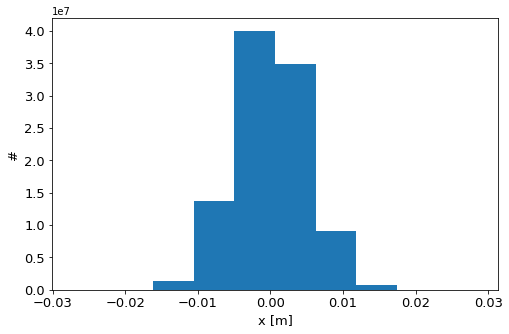

In [6]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:])
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 13)

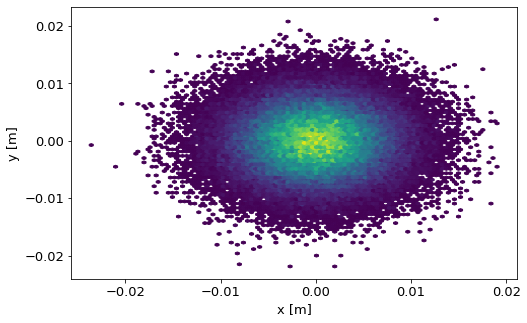

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 13)

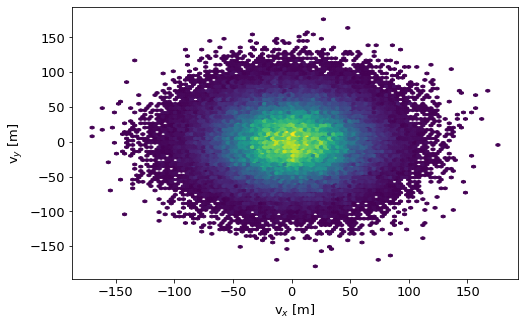

In [9]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 13)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [10]:
in_to_m = (units.imperial.inch).to(units.m)

In [11]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]


In [12]:
coords_full[0,:][m].shape

(5146604,)

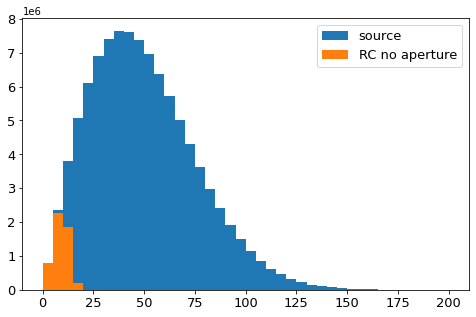

In [13]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 13)
set_fontsize(ax, 13)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [14]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [15]:
distance_aperture_2 = 35.37 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [16]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [17]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

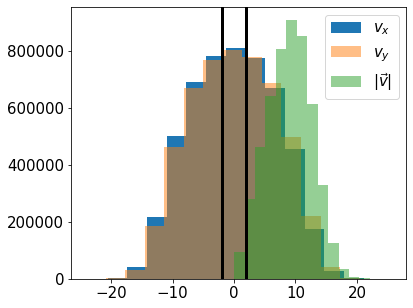

In [18]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 15)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 15)

aperture #1 radius 1.0 mm
accepted 2.8% of trajectories
aperture #1 radius 2.0 mm
accepted 11.1% of trajectories
aperture #1 radius 3.0 mm
accepted 24.2% of trajectories
aperture #1 radius 4.0 mm
accepted 39.7% of trajectories
aperture #1 radius 5.0 mm
accepted 54.5% of trajectories
aperture #1 radius 6.0 mm
accepted 66.3% of trajectories
aperture #1 radius 7.0 mm
accepted 75.5% of trajectories
aperture #1 radius 8.0 mm
accepted 82.6% of trajectories
aperture #1 radius 9.0 mm
accepted 88.0% of trajectories


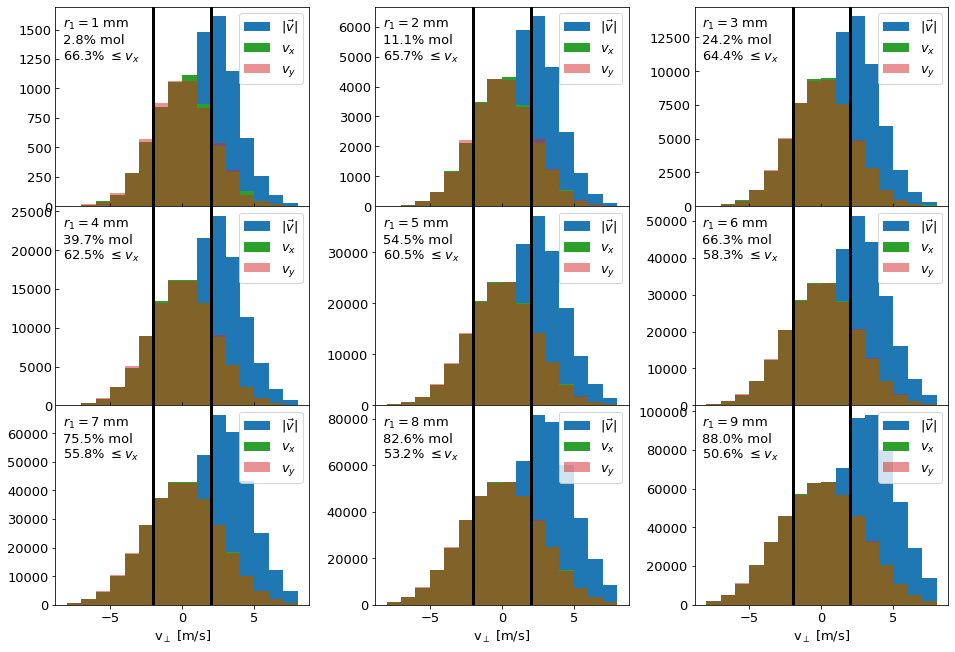

In [19]:
aperture_1_radii = np.linspace(0.001,0.009,9)

percentage_within_limits_1 = {r:0 for r in aperture_1_radii}

bins = np.arange(-8,8+1)

fig, ax = plt.subplots(3,3,figsize = (16,11), sharex = True,
                      gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1,1]})

axp = {r:ax.flatten()[idx] for idx,r in enumerate(aperture_1_radii)}
for r in aperture_1_radii:
    m = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r
    
    axp[r].hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
    axp[r].hist(v_x[m], bins = bins, label = r'$v_x$', color = 'C2')
    axp[r].hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$', color = 'C3')
    
    axp[r].legend(fontsize = 13, loc = 1)
    
    axp[r].axvline(v_acceptable, lw = 3, color = 'k')
    axp[r].axvline(-v_acceptable, lw = 3, color = 'k')

    axp[r].set_xlabel(r'v$_\perp$ [m/s]')

    set_fontsize(axp[r], 13)
    
    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam and assuming a velocity range the laser 
    can interact with.
    """
    dt = distance_laser_rc/v_z[m]
    m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
    interact = m_interact.sum()/interaction_rc*100
    print('='*30)
    print(f'aperture #1 radius {r*1e3:.1f} mm')
    print(f'accepted {interact:.1f}% of trajectories')
    
    
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
#     v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
#     percentage_within_limits_1[r] = (100*(v_abs < v_acceptable).sum()/m.sum())
    # only v_x doppler shifts
    percentage_within_limits_1[r] = (100*(np.abs(v_x[m]) <= v_acceptable).sum()/m.sum())
    
    text = f'$r_1 = ${r*1e3:.0f} mm'+'\n'
    text += f'{interact:.1f}% mol'+'\n'
    text += f'{(100*(np.abs(v_x[m]) <= v_acceptable).sum()/m.sum()):.1f}% $\leq v_x$'
    axp[r].text(0.03, 0.95, text, transform = axp[r].transAxes,
                ha = 'left', va = 'top', fontsize = 13)
    
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

aperture #2 radius 1.0 mm
accepted 1.7% of trajectories
aperture #2 radius 2.0 mm
accepted 6.8% of trajectories
aperture #2 radius 3.0 mm
accepted 15.2% of trajectories
aperture #2 radius 4.0 mm
accepted 26.4% of trajectories
aperture #2 radius 5.0 mm
accepted 39.4% of trajectories
aperture #2 radius 6.0 mm
accepted 50.0% of trajectories
aperture #2 radius 7.0 mm
accepted 59.1% of trajectories
aperture #2 radius 8.0 mm
accepted 66.9% of trajectories
aperture #2 radius 9.0 mm
accepted 74.0% of trajectories


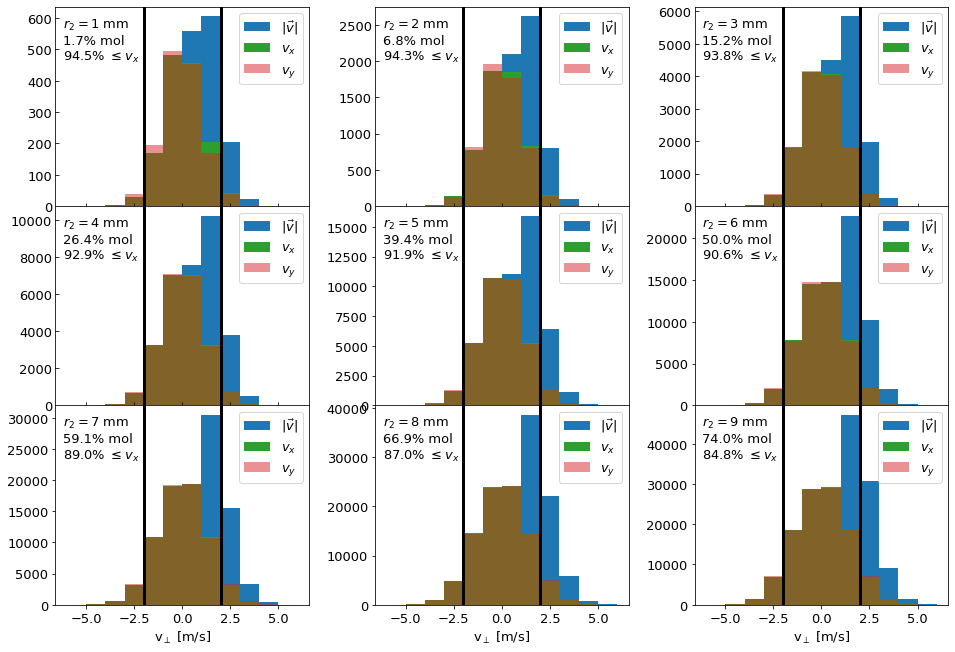

In [20]:
aperture_2_radii = np.linspace(0.001,0.009,9)

percentage_within_limits_2 = {r:0 for r in aperture_2_radii}

fig, ax = plt.subplots(3,3,figsize = (16,11), sharex = True,
                      gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1,1]})

bins = np.arange(-6,6+1)

axp = {r:ax.flatten()[idx] for idx,r in enumerate(aperture_2_radii)}
for r in aperture_2_radii:
    m = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r

    axp[r].hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
    axp[r].hist(v_x[m], bins = bins, label = r'$v_x$', color = 'C2')
    axp[r].hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$', color = 'C3')
    
    axp[r].legend(fontsize = 13, loc = 1)
    
    axp[r].axvline(v_acceptable, lw = 3, color = 'k')
    axp[r].axvline(-v_acceptable, lw = 3, color = 'k')
    
    axp[r].set_xlabel(r'v$_\perp$ [m/s]')
    
    set_fontsize(axp[r], 13)
    
    
    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam and assuming a velocity range the laser 
    can interact with.
    """
    dt = distance_laser_lif/v_z[m]
    m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
    interact = m_interact.sum()/interaction_lif*100
    print('='*30)
    print(f'aperture #2 radius {r*1e3:.1f} mm')
    print(f'accepted {interact:.1f}% of trajectories')
    
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
#     v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
#     percentage_within_limits_2[r] = (100*(v_abs < v_acceptable).sum()/m.sum())
    # only v_x doppler shifts
    percentage_within_limits_2[r] = (100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum())
    
    text = f'$r_2 = ${r*1e3:.0f} mm'+'\n'
    text += f'{interact:.1f}% mol'+'\n'
    text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq v_x$'
    axp[r].text(0.03, 0.95, text, transform = axp[r].transAxes,
                ha = 'left', va = 'top', fontsize = 13)
    
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

In [21]:
from tqdm import tqdm

aperture_1_radii = np.linspace(0.001,0.01,51)
aperture_2_radii = np.linspace(0.001,0.01,51)
radii = list(product(aperture_1_radii, aperture_2_radii))

percentage_within_limits_both = {(r1,r2):0 for r1,r2 in radii}
molecules_accepted_both = {(r1,r2):0 for r1,r2 in radii}

for r1,r2 in tqdm(radii):
    
    m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
    m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
    m = m1 & m2   
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
#     v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
#     percentage_within_limits_both[(r1,r2)] = (100*(v_abs < v_acceptable).sum()/m.sum())
    # only v_x doppler shifts
    percentage_within_limits_both[(r1,r2)] = (100*(np.abs(v_x[m]) <= v_acceptable).sum()/m.sum())

    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam and assuming a velocity range the laser 
    can interact with.
    """
    dt = distance_laser_lif/v_z[m]
    m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
    interact = m_interact.sum()/interaction_lif*100
    molecules_accepted_both[(r1,r2)] = interact

100%|██████████████████████████████████████████████████████████████████████████████| 2601/2601 [07:37<00:00,  5.68it/s]


In [22]:
from matplotlib import cm
cmap = cm.get_cmap('viridis')
cmap.set_bad('w')

<ipython-input-22-8fa936662a2d>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad('w')


<ipython-input-23-eb24983c67da>:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cbar.cmap.set_over('white')


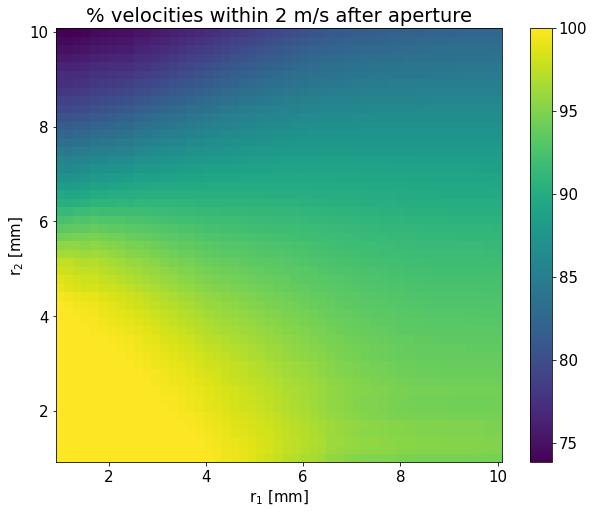

In [23]:
from scipy import interpolate

r1,r2 = zip(*list(percentage_within_limits_both.keys()))
data = np.array(list(percentage_within_limits_both.values()))

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)
cbar.cmap.set_over('white')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'% velocities within {v_acceptable} m/s after aperture')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

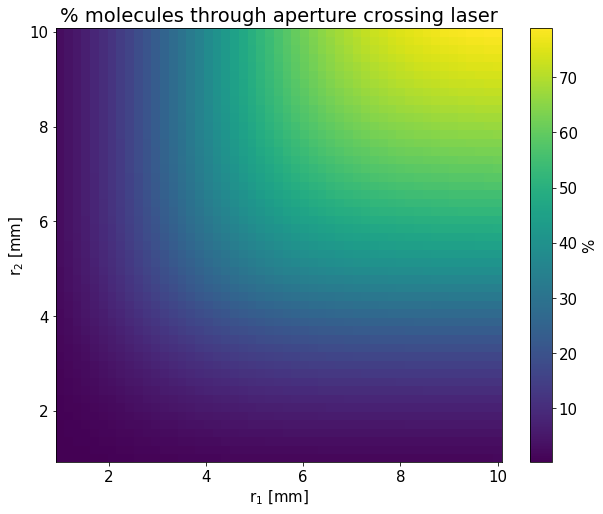

In [24]:
from scipy import interpolate

r1,r2 = zip(*list(molecules_accepted_both.keys()))
data = np.array(list(molecules_accepted_both.values()))

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('%')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title('% molecules through aperture crossing laser')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

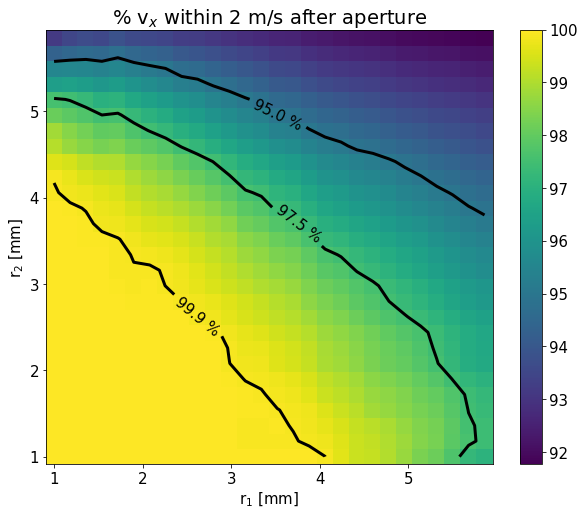

In [25]:
r1_lim = 0.006
r2_lim = 0.006
r1 = []
r2 = []
data = []
for (r_1,r_2),d in percentage_within_limits_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)

cs = ax.contour(X*1e3,Y*1e3,Z, colors = 'k', levels = [95, 97.5, 99.9], linewidths = 3)
ax.clabel(cs, fontsize = 15, fmt = '%.1f %%')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'% v$_x$ within {v_acceptable} m/s after aperture')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

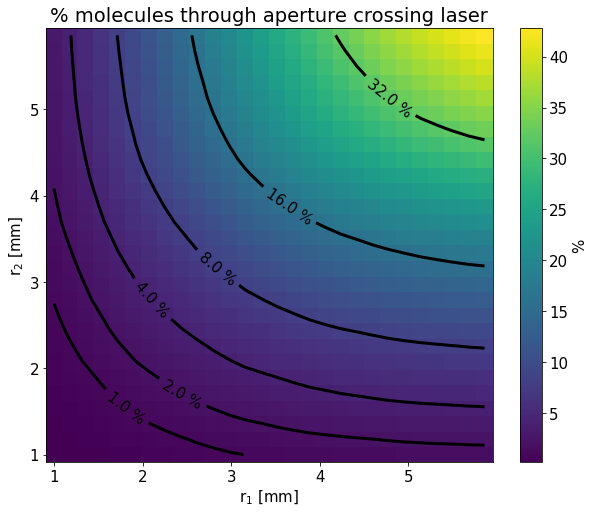

In [26]:
r1 = []
r2 = []
data = []
for (r_1,r_2),d in molecules_accepted_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)
        

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('%')

cs = ax.contour(X*1e3,Y*1e3,Z, colors = 'k', levels = [1,2,4,8,16,32], linewidths = 3)
ax.clabel(cs, fontsize = 15, fmt = '%.1f %%')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title('% molecules through aperture crossing laser')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

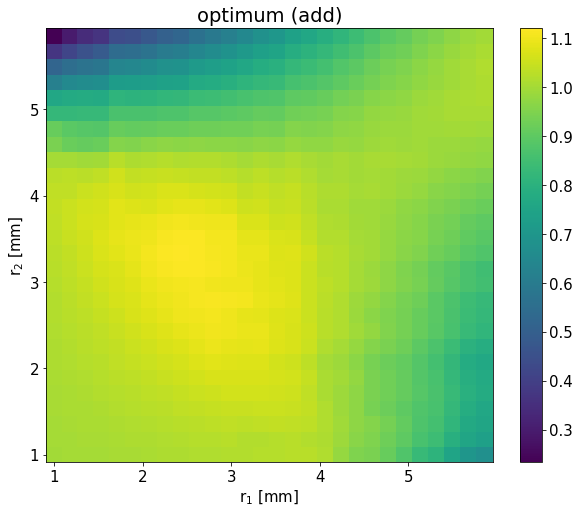

In [27]:
r1_lim = 0.006
r2_lim = 0.006
r1 = []
r2 = []
data = []
for (r_1,r_2),d in percentage_within_limits_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Zv = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

r1 = []
r2 = []
data = []
for (r_1,r_2),d in molecules_accepted_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

Zm = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,((Zv-Zv.min())/Zv.ptp())+((Zm-Zm.min())/Zm.ptp()), shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'optimum (add)')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

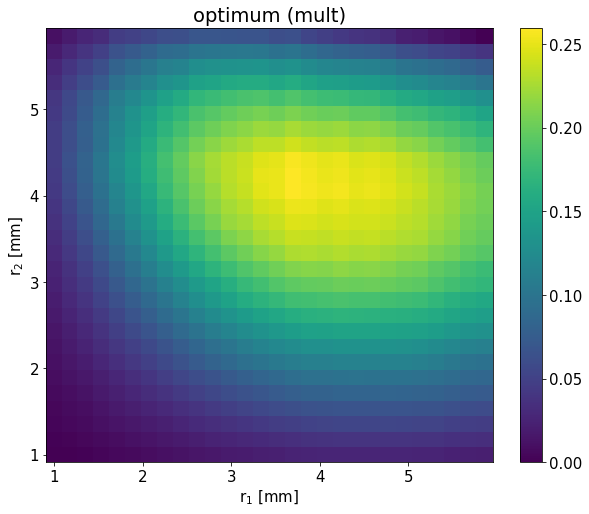

In [28]:
r1_lim = 0.006
r2_lim = 0.006
r1 = []
r2 = []
data = []
for (r_1,r_2),d in percentage_within_limits_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

X,Y = np.meshgrid(np.unique(r1), np.unique(r2))
Zv = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

r1 = []
r2 = []
data = []
for (r_1,r_2),d in molecules_accepted_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

Zm = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,((Zv-Zv.min())/Zv.ptp()) * ((Zm-Zm.min())/Zm.ptp()), shading = 'nearest', cmap = cmap)
cbar = fig.colorbar(c, ax = ax)

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'optimum (mult)')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

In [33]:
a = ((Zv-Zv.min())/Zv.ptp()) * ((Zm-Zm.min())/Zm.ptp())
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)
print(X[ind], Y[ind])

0.0037 0.00406


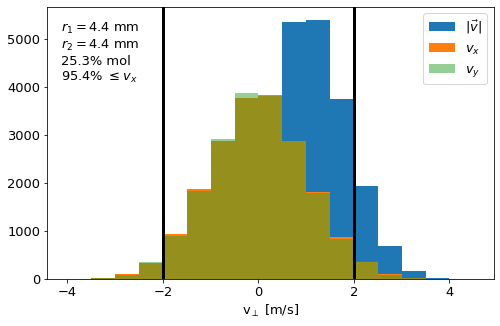

In [50]:
r1 = 4.4e-3
r2 = 4.4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 13, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')

set_fontsize(ax, 13)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

percentage_within_limits_both[(r1,r2)] = (100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum())

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq v_x$'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 13);